In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
import pandasql as psql
import math
import numpy as np
import os

# Data Import

In [ ]:
# create dataframe
time_tracking = pd.read_csv('time-tracking.csv')

# change date columns to datetime
time_tracking['datetime'] = time_tracking['datetime'].astype('datetime64[s]')

# Add days of week, week #, and year columns to time_tracking
time_tracking['day_of_week'] = time_tracking['datetime'].dt.day_name() 
time_tracking['year'] = time_tracking['datetime'].dt.year
time_tracking['week'] = time_tracking['datetime'].dt.isocalendar().week

In [3]:
time_tracking

activity            datetime  hours  client_id  project_id  \
0         Client Production 2016-11-08 13:16:00   1.58        NaN         NaN   
1         Client Production 2016-11-08 15:08:00   1.53        NaN         NaN   
2         Client Production 2016-11-09 11:48:00   1.50        NaN         NaN   
3         Client Production 2016-11-09 13:45:00   1.55        NaN         NaN   
4         Client Production 2016-11-11 11:36:00   1.50        NaN         NaN   
...                     ...                 ...    ...        ...         ...   
8233      Client Production 2024-01-04 21:14:00   1.22        NaN         NaN   
8234                   Spec 2024-01-05 08:44:00   1.82        NaN         NaN   
8235           Sound Design 2024-01-05 12:10:00   0.83        NaN         NaN   
8236                  Admin 2024-01-05 14:07:00   1.82        NaN         NaN   
8237  Programming Portfolio 2024-01-05 16:00:00   1.82        NaN         NaN   

     day_of_week  year  week  
0        Tuesday  2016    45  
1        Tuesday  2016    45  
2      Wednesday  2016    45  
3      Wednesday  2016    45  
4         Friday  2016    45  
...          ...   ...   ...  
8233    Thursday  2024     1  
8234      Friday  2024     1  
8235      Friday  2024     1  
8236      Friday  2024     1  
8237      Friday  2024     1  

[8238 rows x 8 columns]

# Exploratory Analysis

### Total Hours Separated by Activity

Let's begin with an overview of all productive hours tracked for different activities. 

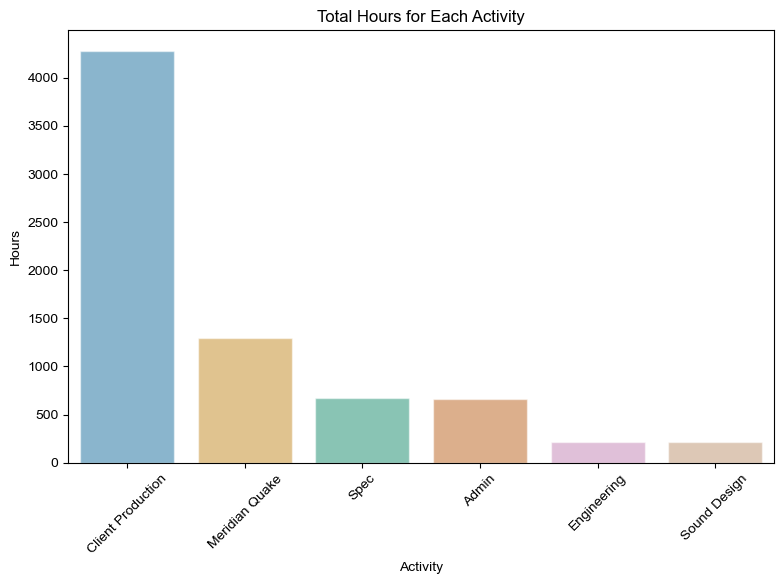

In [ ]:
# Filter business activities from tracking input
business_activities = ['Client Production', 'Meridian Quake', 'Spec', 'Admin', 'Sound Design', 'Engineering']
time_tracking_business = time_tracking[time_tracking['activity'].isin(business_activities)]

# sum total business hours by activity type
activity_total_hours = time_tracking_business.groupby('activity').hours.sum().reset_index(name='total_hours')
activity_total_hours = activity_total_hours.sort_values(by='total_hours', ascending=False)
#activity_total_hours.head(20)

# create figure
plt.figure(figsize=(8,6))
ax = plt.subplot()

# Set the style of seaborn
sns.set(style="whitegrid")

# Choose a colorblind-friendly palette
palette = sns.color_palette("colorblind", n_colors=len(activity_total_hours))

# Create the bar plot with the chosen palette
sns.barplot(x='activity', y='total_hours', data=activity_total_hours, palette=palette, alpha = 0.5)
plt.xticks(rotation=45)
plt.xlabel('Activity')
plt.ylabel('Hours')
title = 'Total Hours for Each Activity'
plt.title(title)
plt.tight_layout()  # Ensures that labels and titles fit within the plot area
plt.show()

### How long is a focused productivity session via the Pomodoro Technique?

The average session length is 0.95 hours.


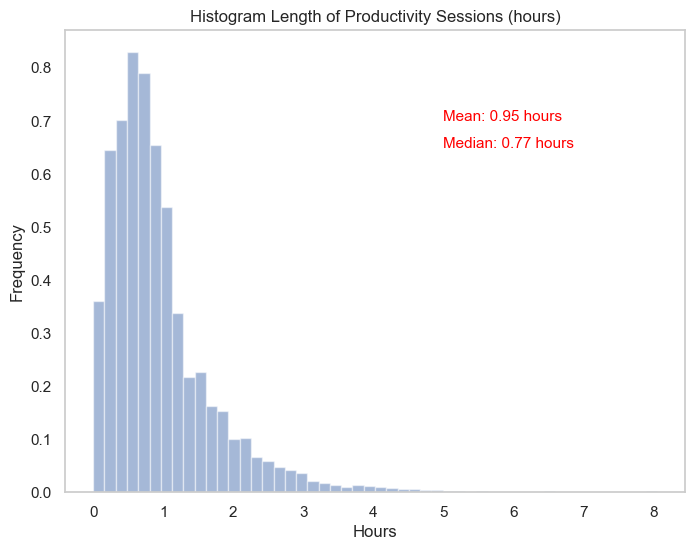

In [ ]:
# Determine average session length
average_session_length = round(time_tracking['hours'].mean(), 2)
median_session_length = round(time_tracking['hours'].median(), 2)
print(f'The average session length is {average_session_length} hours.')

# filter data by hours
column_data = time_tracking['hours']

# plot histogram
plt.figure(figsize=(8,6))
plt.hist(column_data, density=True, bins= 50, alpha = 0.5)
title = 'Histogram Length of Productivity Sessions (hours)'
plt.xlabel('Hours')
plt.ylabel('Frequency')
plt.title(title)
plt.grid(False)
plt.text(5,0.7, f'Mean: {average_session_length} hours', color='red', fontsize=11)
plt.text(5,0.65, f'Median: {median_session_length} hours', color='red', fontsize=11)
# save figure for reporting
plt.show()


### Productivity By Day of Week and By Month

In [6]:
# List business activities
business_activities = ['Client Production', 'Meridian Quake', 'Spec', 'Admin', 'Sound Design', 'Engineering']

# Filter the years to be greater than 2016 and less than the current year
current_year = datetime.datetime.now().year
unique_years_temp = time_tracking[(time_tracking['activity'].isin(business_activities)) 
                                                & (time_tracking['year'] < current_year) 
                                                & (time_tracking['year'] > 2016)]

# Create list of years
years_list = unique_years_temp['year'].unique().tolist()
print(years_list)

[2017, 2018, 2019, 2020, 2021, 2022, 2023]


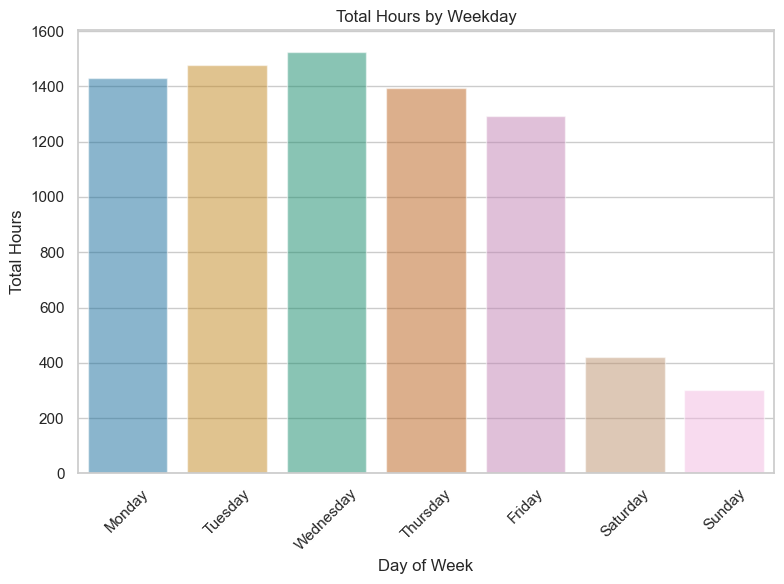

In [ ]:
# Are certain days of the week more productive?

# SQL: Sum hours by days of week and order by weekday
query = '''
    SELECT
        CASE
            WHEN day_of_week = 'Monday' THEN 1
            WHEN day_of_week = 'Tuesday' THEN 2
            WHEN day_of_week = 'Wednesday' THEN 3
            WHEN day_of_week = 'Thursday' THEN 4
            WHEN day_of_week = 'Friday' THEN 5
            WHEN day_of_week = 'Saturday' THEN 6
            WHEN day_of_week = 'Sunday' THEN 7
            ELSE 8 -- This handles any unexpected values
        END AS numeric_day,
        day_of_week,
        SUM(hours) AS total_hours
    FROM time_tracking
    GROUP BY 1
    ORDER BY 1 ASC;
    '''

# create dataframe from query
weekday_totals = psql.sqldf(query, locals())

plt.figure(figsize=(8,6))
ax = plt.subplot()

# Set the style of seaborn
sns.set(style="whitegrid")

# Choose a colorblind-friendly palette
palette = sns.color_palette("colorblind", n_colors=len(weekday_totals))

# Create the bar plot with the chosen palette
sns.barplot(x='day_of_week', y='total_hours', data=weekday_totals, palette=palette, alpha = 0.5)
plt.xticks(rotation=45)
plt.xlabel('Day of Week')
plt.ylabel('Total Hours')
title = 'Total Hours by Weekday'
plt.title(title)
plt.tight_layout()  # Ensures that labels and titles fit within the plot area
plt.show()


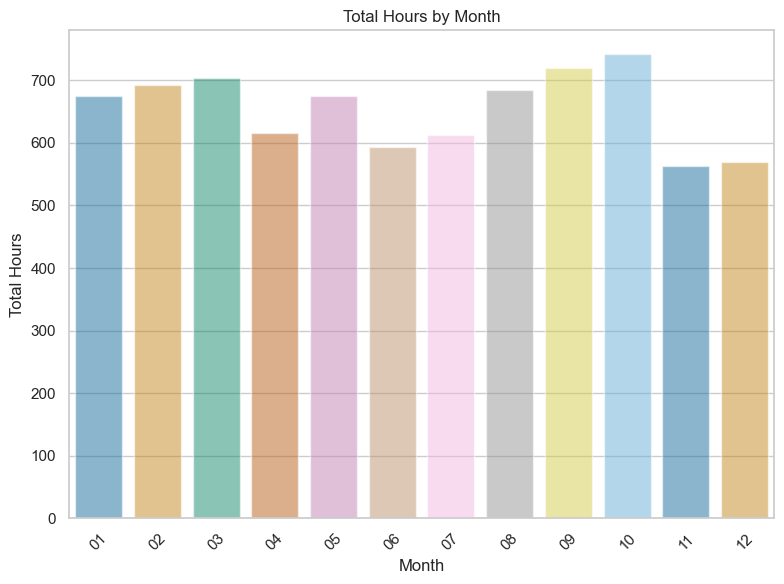

In [ ]:
# How does Productivity change by month?

# SQL: Sum hours by month and order by month
query = '''
    SELECT strftime('%m', datetime) AS month, SUM(hours) AS total_hours
    FROM time_tracking
    GROUP BY 1
    ORDER BY 1 ASC;
    '''
# create dataframe from query
monthly_hours = psql.sqldf(query, locals())

plt.figure(figsize=(8,6))
ax = plt.subplot()

# Set the style of seaborn
sns.set(style="whitegrid")

# Choose a colorblind-friendly palette
palette = sns.color_palette("colorblind", n_colors=len(monthly_hours))

# Create the bar plot with the chosen palette
sns.barplot(x='month', y='total_hours', data=monthly_hours, palette=palette, alpha = 0.5)
plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Total Hours')
title = 'Total Hours by Month'
plt.title(title)
plt.tight_layout()  # Ensures that labels and titles fit within the plot area
plt.show()

### Productivity by Time of Day

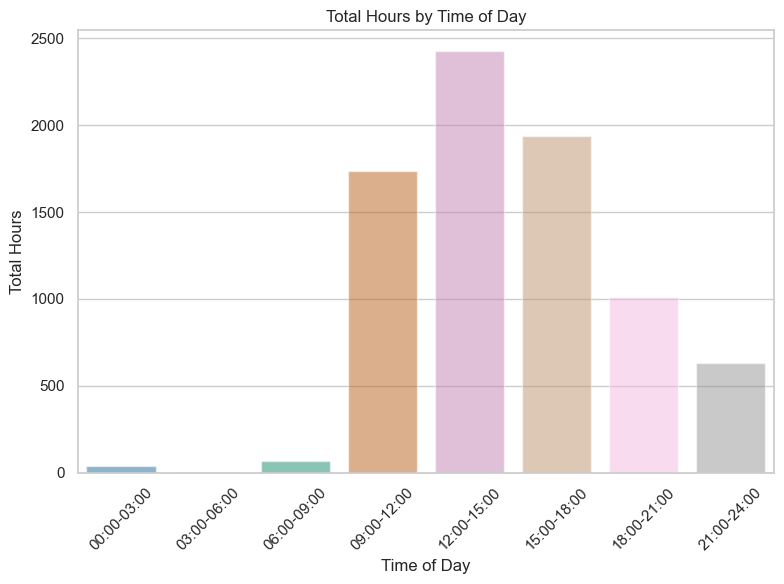

In [ ]:
# Are certain times of day when I am more productive?

# SQL: Sum hours by time of day and order by time of day
query = '''
    SELECT
        CASE
            WHEN CAST(strftime('%H', datetime) AS INTEGER) >= 0 AND CAST(strftime('%H', datetime) AS INTEGER) < 3 THEN '00:00-03:00'
            WHEN CAST(strftime('%H', datetime) AS INTEGER) >= 3 AND CAST(strftime('%H', datetime) AS INTEGER) < 6 THEN '03:00-06:00'
            WHEN CAST(strftime('%H', datetime) AS INTEGER) >= 6 AND CAST(strftime('%H', datetime) AS INTEGER) < 9 THEN '06:00-09:00'
            WHEN CAST(strftime('%H', datetime) AS INTEGER) >= 9 AND CAST(strftime('%H', datetime) AS INTEGER) < 12 THEN '09:00-12:00'
            WHEN CAST(strftime('%H', datetime) AS INTEGER) >= 12 AND CAST(strftime('%H', datetime) AS INTEGER) < 15 THEN '12:00-15:00'
            WHEN CAST(strftime('%H', datetime) AS INTEGER) >= 15 AND CAST(strftime('%H', datetime) AS INTEGER) < 18 THEN '15:00-18:00'
            WHEN CAST(strftime('%H', datetime) AS INTEGER) >= 18 AND CAST(strftime('%H', datetime) AS INTEGER) < 21 THEN '18:00-21:00'
            WHEN CAST(strftime('%H', datetime) AS INTEGER) >= 21 AND CAST(strftime('%H', datetime) AS INTEGER) <= 23 THEN '21:00-24:00'
        END AS time_of_day,
        SUM(hours) as total_hours
    FROM time_tracking
    GROUP BY 1
    ORDER BY
        CASE
            WHEN time_of_day = '0-3' THEN 1
            WHEN time_of_day = '3-6' THEN 2
            WHEN time_of_day = '6-9' THEN 3
            WHEN time_of_day = '9-12' THEN 4
            WHEN time_of_day = '12-15' THEN 5
            WHEN time_of_day = '15-18' THEN 6
            WHEN time_of_day = '18-21' THEN 7
            WHEN time_of_day = '21-24' THEN 8
        END ASC;
    '''
# create dataframe from query
time_of_day = psql.sqldf(query, locals())

plt.figure(figsize=(8,6))
ax = plt.subplot()

# Set the style of seaborn
sns.set(style="whitegrid")

# Choose a colorblind-friendly palette
palette = sns.color_palette("colorblind", n_colors=len(time_of_day))

# Create the bar plot with the chosen palette
sns.barplot(x='time_of_day', y='total_hours', data=time_of_day, palette=palette, alpha = 0.5)
plt.xticks(rotation=45)
plt.xlabel('Time of Day')
plt.ylabel('Total Hours')
title = 'Total Hours by Time of Day'
plt.title(title)
plt.tight_layout()  # Ensures that labels and titles fit within the plot area
plt.show()

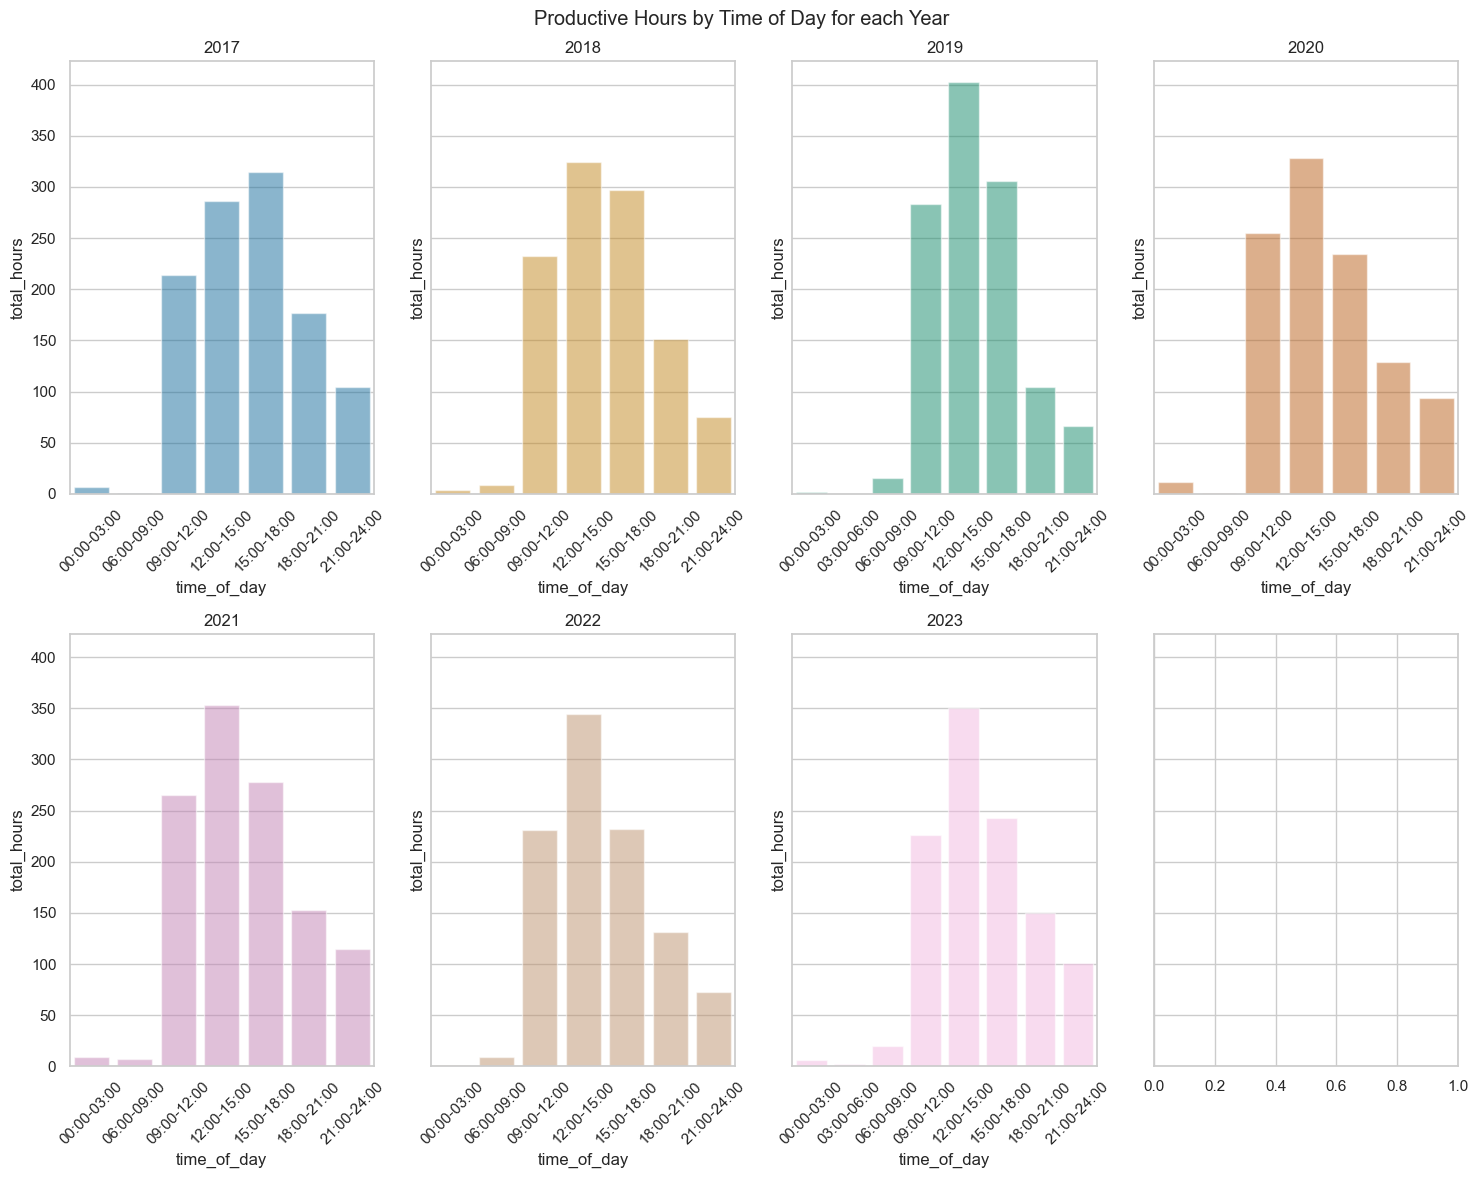

In [ ]:
# How has my productivity by time of day changed over the years?

# get number of subplots
number_of_subplots = len(years_list)

# set the number of rows for the subplot
if number_of_subplots <= 4:
    rows = 1
elif number_of_subplots <= 8:
    rows = 2
elif number_of_subplots <= 12:
    rows = 3
else:
    print('Too many categories.')

# determine max number of columns
columns = math.ceil(number_of_subplots/rows)

# set subplot and palette indices for use in loop
subplot_index = 1
palette_index = 0

# create color palette
palette_list = sns.color_palette('colorblind', len(years_list))

# create subplots by iterating through 'categories_list' 
fig, ax = plt.subplots(rows, columns, figsize=(15,12), sharey=True)

for year in years_list:

    # filter dataframe by category
    query_data = time_tracking[time_tracking['year'] == year]

    # perform query
    query = '''
    SELECT
        CASE
            WHEN CAST(strftime('%H', datetime) AS INTEGER) >= 0 AND CAST(strftime('%H', datetime) AS INTEGER) < 3 THEN '00:00-03:00'
            WHEN CAST(strftime('%H', datetime) AS INTEGER) >= 3 AND CAST(strftime('%H', datetime) AS INTEGER) < 6 THEN '03:00-06:00'
            WHEN CAST(strftime('%H', datetime) AS INTEGER) >= 6 AND CAST(strftime('%H', datetime) AS INTEGER) < 9 THEN '06:00-09:00'
            WHEN CAST(strftime('%H', datetime) AS INTEGER) >= 9 AND CAST(strftime('%H', datetime) AS INTEGER) < 12 THEN '09:00-12:00'
            WHEN CAST(strftime('%H', datetime) AS INTEGER) >= 12 AND CAST(strftime('%H', datetime) AS INTEGER) < 15 THEN '12:00-15:00'
            WHEN CAST(strftime('%H', datetime) AS INTEGER) >= 15 AND CAST(strftime('%H', datetime) AS INTEGER) < 18 THEN '15:00-18:00'
            WHEN CAST(strftime('%H', datetime) AS INTEGER) >= 18 AND CAST(strftime('%H', datetime) AS INTEGER) < 21 THEN '18:00-21:00'
            WHEN CAST(strftime('%H', datetime) AS INTEGER) >= 21 AND CAST(strftime('%H', datetime) AS INTEGER) <= 23 THEN '21:00-24:00'
        END AS time_of_day,
        SUM(hours) as total_hours
    FROM query_data
    GROUP BY 1
    ORDER BY
        CASE
            WHEN time_of_day = '0-3' THEN 1
            WHEN time_of_day = '3-6' THEN 2
            WHEN time_of_day = '6-9' THEN 3
            WHEN time_of_day = '9-12' THEN 4
            WHEN time_of_day = '12-15' THEN 5
            WHEN time_of_day = '15-18' THEN 6
            WHEN time_of_day = '18-21' THEN 7
            WHEN time_of_day = '21-24' THEN 8
        END ASC;
    '''
    # create dataframe from query
    plot_data = psql.sqldf(query, locals())

    # plot subplot
    plt.subplot(rows, columns, subplot_index)
    ax = sns.barplot(x = plot_data.iloc[:,0], y = plot_data.iloc[:,1], data = plot_data, color= palette_list[palette_index], alpha = 0.5)
    plt.title(year)
    plt.xticks(rotation=45)

    # advance plot indices
    subplot_index += 1
    palette_index += 1

# title and save overall figure
fig.suptitle('Productive Hours by Time of Day for each Year')
plt.tight_layout()
plt.show()

### Analysis of Optimal Productivity Days

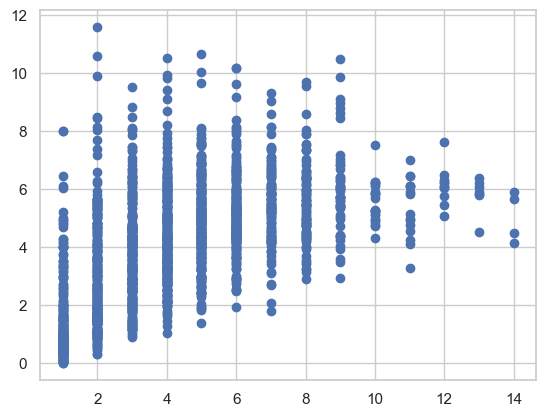

In [27]:
# Is the number of clock ins correlated with the total daily productive hours?

total_hours_by_day_all = time_tracking.groupby(time_tracking['datetime'].dt.date).agg(
    hours = ('hours', 'sum'),
    clock_in_count = ('datetime', 'count'),
    day_start_time = ('datetime', 'min'),
    num_unique_activities = ('activity', 'nunique')
    ).reset_index()

total_hours_by_day_all

plt.scatter(total_hours_by_day_all['clock_in_count'], total_hours_by_day_all['hours'])

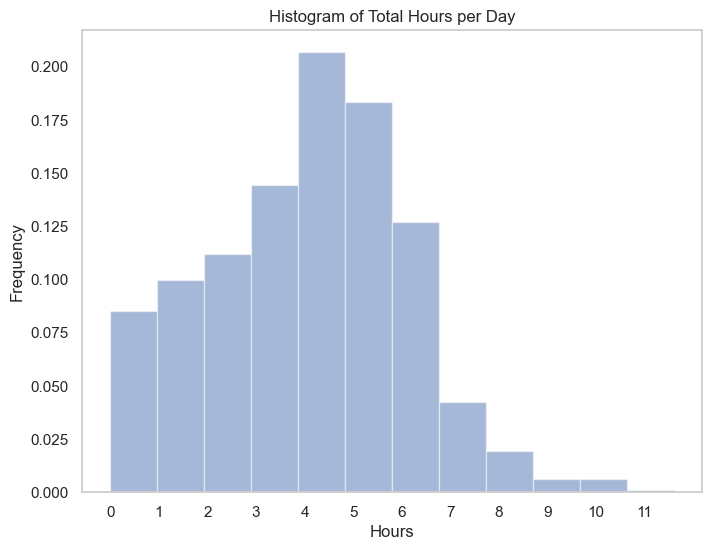

In [65]:
# Find ceiling of most hours worked in a day
max_hours_ceiling = math.ceil(total_hours_by_day_all['hours'].max())

plt.figure(figsize=(8,6))
plt.hist(total_hours_by_day_all['hours'], bins=max_hours_ceiling, density=True, alpha=0.5)
plt.title('Histogram of Total Hours per Day')
plt.grid(False)
x_ticks = list(range(0, max_hours_ceiling))
plt.xticks(x_ticks)
plt.xlabel('Hours')
plt.ylabel('Frequency')
plt.show()

What is the ratio of optimal days to all days?

In [11]:
#remove weekends
weekday_time_tracking = time_tracking[(time_tracking['day_of_week'] != 'Saturday') & (time_tracking['day_of_week'] != 'Sunday')]

# groupby date: sum hours and add count of clock ins
total_hours_by_day = weekday_time_tracking.groupby(weekday_time_tracking['datetime'].dt.date).agg(
    hours = ('hours', 'sum'),
    clock_in_count = ('datetime', 'count'),
    day_start_time = ('datetime', 'min'),
    num_unique_activities = ('activity', 'nunique')
    ).reset_index()

# create bounds for optimal days
optimal_days_min_hours = 4.5
optimal_days_max_hours = 7

# make dataframe of optimal days between 4.5 and 5.5 hours
optimal_days = total_hours_by_day[(total_hours_by_day['hours'] >= optimal_days_min_hours) & (total_hours_by_day['hours'] <= optimal_days_max_hours)].reset_index(drop=True)

# convert datetime column to datetime
optimal_days['datetime'] = pd.to_datetime(optimal_days['datetime'])

# calculate ratio of optimal days
ratio_optimal_days = round(len(optimal_days)/len(total_hours_by_day), 3) * 100

print(f'Percentage of days between {optimal_days_min_hours} and {optimal_days_max_hours} hours: {ratio_optimal_days}%. This is the ratio of optimal days')


Percentage of days between 4.5 and 7 hours: 42.8%. This is the ratio of optimal days


In [25]:
optimal_days['hours']

0      5.62
1      5.22
2      6.88
3      5.13
4      5.65
       ... 
692    5.92
693    4.68
694    5.58
695    5.35
696    6.29
Name: hours, Length: 697, dtype: float64

What time of day do I start working on optimal productive days? Let's define an optimal day as 4.5 to 5.5 hours of productivity.?

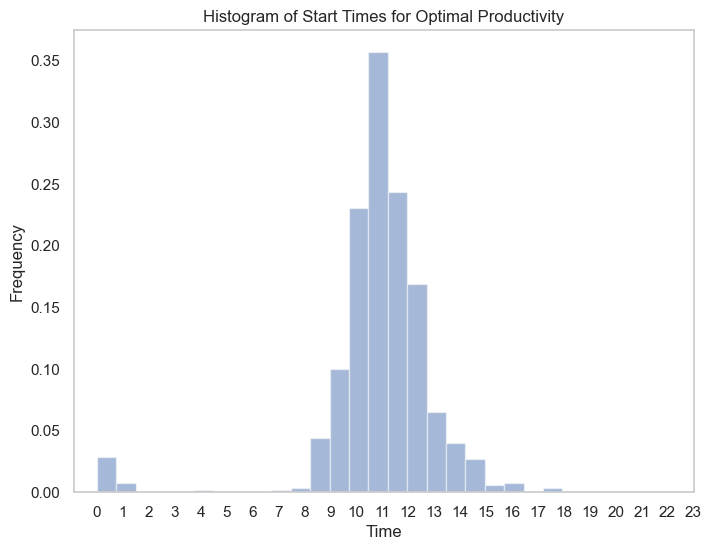

In [ ]:
# what's the distribution of clock in times on these productive days?

# convert datetime column to integer between 1 and 24 for plotting
optimal_days['hour_dt'] = optimal_days['day_start_time'].dt.hour
optimal_days['minute_dt'] = optimal_days['day_start_time'].dt.minute
optimal_days['time_float'] = round(optimal_days['hour_dt'] + optimal_days['minute_dt']/60, 2)

# histogram of day_start_time
plt.figure(figsize=(8,6))
plt.hist(optimal_days['time_float'], density=True, bins= 24, alpha = 0.5)
title = 'Histogram of Start Times for Optimal Productivity'
x_ticks = list(range(0, 24))
plt.xticks(x_ticks)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title(title)
plt.grid(False)
# save figure for reporting
plt.show()

What is the distribution of the number of clock in events on optimal days?

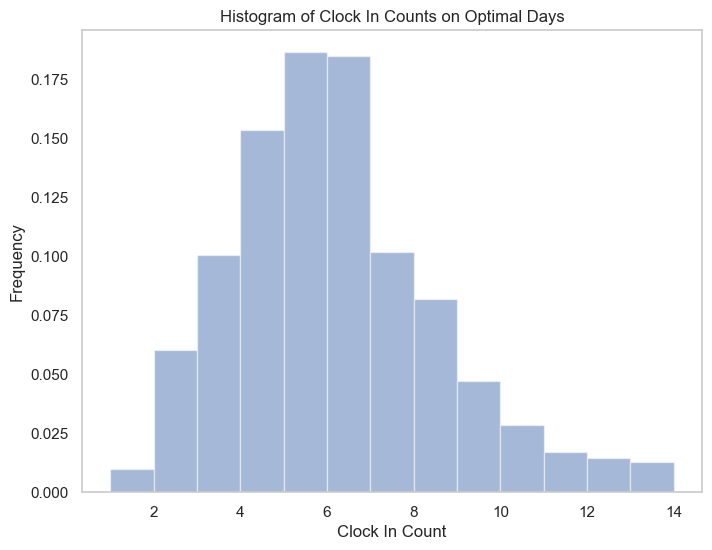

In [ ]:
# histogram of clock_in_count
plt.figure(figsize=(8,6))
plt.hist(optimal_days['clock_in_count'], density=True, bins= 13, alpha = 0.5)
title = 'Histogram of Clock In Counts on Optimal Days'
plt.xlabel('Clock In Count')
plt.ylabel('Frequency')
plt.title(title)
plt.grid(False)
# save figure for reporting
plt.show()

What is the distribution of counts of unique activities on optimal days? Am I more productive on a narrow or diverse range of tasks?

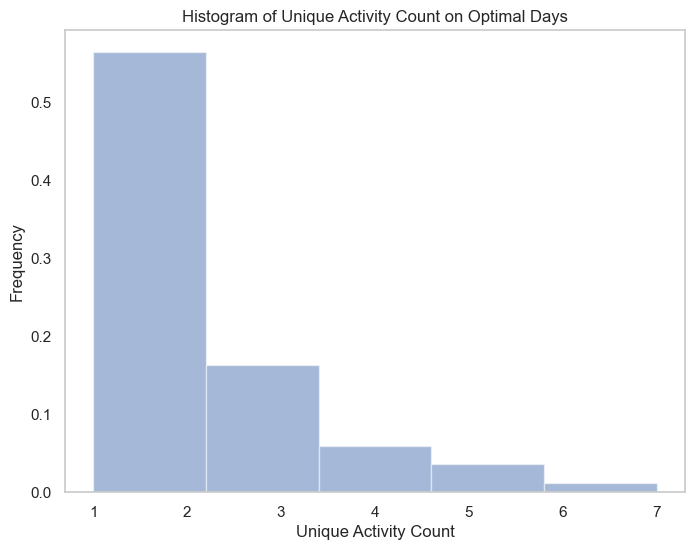

In [ ]:
# histogram of unique activities
plt.figure(figsize=(8,6))
plt.hist(optimal_days['num_unique_activities'], density=True, bins= 5, alpha = 0.5)
title = 'Histogram of Unique Activity Count on Optimal Days'
plt.xlabel('Unique Activity Count')
plt.ylabel('Frequency')
plt.title(title)
plt.grid(False)
# save figure for reporting
plt.show()

Make a distribution of 'Optimal Streaks' to see how likely I am to string together productive days.


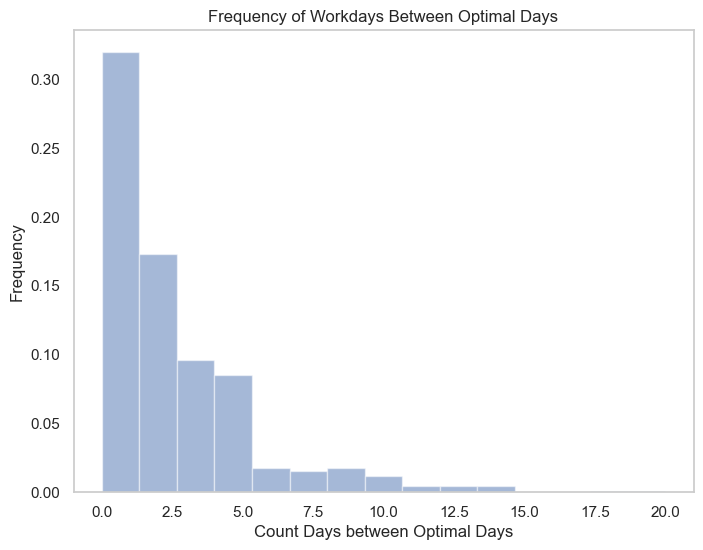

In [ ]:
# create column of days since last optimal day
# Calculate the difference between consecutive rows in days and store it as an integer
#optimal_days['days_between'] = (optimal_days['datetime'] - optimal_days['datetime'].shift()).dt.days

# determine the number of workdays between date_time values
def calculate_workdays_between(row, date_column='datetime', df=None):
    date_str = row[date_column].strftime('%Y-%m-%d')
    if df.index[df[date_column] == row[date_column]].tolist()[0] != 0:
        prev_date_str = df.loc[df.index[df[date_column] == row[date_column]] - 1, date_column].iloc[0].strftime('%Y-%m-%d')
        return np.busday_count(prev_date_str, date_str)
    return 0

# Assuming optimal_days is your DataFrame and 'datetime' is your datetime column
optimal_days['workdays_between'] = optimal_days.apply(lambda row: calculate_workdays_between(row, df=optimal_days), axis=1)

# histogram of unique activities
plt.figure(figsize=(8,6))
plt.hist(optimal_days['workdays_between'], density=True, bins= 15, alpha = 0.5)
title = 'Frequency of Workdays Between Optimal Days'
plt.xlabel('Count Days between Optimal Days')
plt.ylabel('Frequency')
plt.title(title)
plt.grid(False)
# save figure for reporting
plt.show()

### Duplicate Data (discovery and cleaning)

In [18]:
total_hours_by_day_all.describe()

hours  clock_in_count       day_start_time  num_unique_activities
count  1921.000000     1921.000000                 1921            1921.000000
mean      4.083717        4.288391  2020-06-22 05:38:21               1.916189
min       0.000000        1.000000  2016-11-08 13:16:00               1.000000
25%       2.600000        2.000000  2018-09-05 11:19:00               1.000000
50%       4.270000        4.000000  2020-06-11 13:27:00               2.000000
75%       5.480000        6.000000  2022-05-05 18:46:00               2.000000
max      11.600000       14.000000  2024-01-05 08:44:00               7.000000
std       2.029761        2.464987                  NaN               1.024570

In [19]:
## what's happening with the 19 hours outlier? Has to be a mistake in data, let's investigate. Data fixed, outputs before fix added as comments.
#total_hours_by_day_all.describe()

'''
hours	clock_in_count	day_start_time	num_unique_activities
count	1846.000000	1846.000000	1846	1846.000000
mean	4.502882	4.495666	2020-04-26 13:44:39	1.927952
min	0.000000	1.000000	2016-11-08 14:51:00	1.000000
25%	2.750000	3.000000	2018-08-08 18:58:15	1.000000
50%	4.400000	4.000000	2020-04-21 02:24:30	2.000000
75%	5.860000	6.000000	2022-01-26 08:24:00	2.000000
max	19.660000	16.000000	2023-09-18 11:22:00	7.000000
std	2.582138	2.577941	NaN	0.963681
'''

## Find the row with the maximum 'hours' value
#max_hours_row = total_hours_by_day_all.loc[total_hours_by_day_all['hours'].idxmax()]

## Now, max_hours_row contains the row with the maximum 'hours' value
#max_hours_row

'''
datetime                          2017-08-15
hours                                  19.66
clock_in_count                             8
day_start_time           2017-08-15 15:15:00
num_unique_activities                      2
Name: 198, dtype: object
'''
# further investigation in the raw data showed duplicate data. I will manually fix in the database.
# I found a handful of duplicated data, mostly between spec and 'client production' I was able to de-deduplicate up the data stream

# discovered I had ~800 rows of duplicate data. The complication is that the activity status was different in the duplicate data.

'\ndatetime                          2017-08-15\nhours                                  19.66\nclock_in_count                             8\nday_start_time           2017-08-15 15:15:00\nnum_unique_activities                      2\nName: 198, dtype: object\n'

I discovered I had ~800 rows of duplicate data. The complication is that the activity status was different in the duplicate data. It seems that there was an error in IFTTT input and multiple activities where triggered at once. I was able to deduplicate the data in a different python script. I cross verified the new data against the project_hours dataframe and there were no changes, suggesting a successful and clean deduplication. 

This was a lesson in identifying and treating a problem in the dataset. 

In [20]:

# Find the row with the maximum 'hours' value
max_hours_row = total_hours_by_day_all.loc[total_hours_by_day_all['hours'].idxmax()]

# Now, max_hours_row contains the row with the maximum 'hours' value
max_hours_row


datetime                          2018-03-13
hours                                   11.6
clock_in_count                             2
day_start_time           2018-03-13 10:36:00
num_unique_activities                      1
Name: 352, dtype: object

In [21]:
# Sort the DataFrame in descending order based on 'hours' column
total_hours_by_day_all_sorted = total_hours_by_day_all.sort_values(by='hours', ascending=False)

# Filter rows where 'hours' is greater than 8 and not in cleared days
outlier_days = total_hours_by_day_all_sorted[total_hours_by_day_all_sorted['hours'] > 8]

outlier_days.head(15)

datetime  hours  clock_in_count      day_start_time  \
352   2018-03-13  11.60               2 2018-03-13 10:36:00   
1021  2020-09-08  10.68               5 2020-09-08 00:08:00   
1016  2020-09-02  10.60               2 2020-09-02 12:36:00   
1020  2020-09-07  10.52               4 2020-09-07 11:36:00   
441   2018-07-19  10.49               9 2018-07-19 00:35:00   
771   2019-09-26  10.20               6 2019-09-26 11:17:00   
236   2017-10-05  10.17               6 2017-10-05 12:25:00   
1215  2021-06-10  10.05               5 2021-06-10 10:34:00   
353   2018-03-14   9.93               4 2018-03-14 12:05:00   
1306  2021-10-15   9.92               2 2021-10-15 09:44:00   
1022  2020-09-09   9.89               9 2020-09-09 00:10:00   
198   2017-08-15   9.83               4 2017-08-15 10:21:00   
1223  2021-06-19   9.70               8 2021-06-19 11:50:00   
671   2019-05-14   9.67               5 2019-05-14 11:18:00   
155   2017-06-14   9.64               6 2017-06-14 11:05:00   

      num_unique_activities  
352                       1  
1021                      1  
1016                      1  
1020                      1  
441                       3  
771                       3  
236                       1  
1215                      1  
353                       2  
1306                      2  
1022                      1  
198                       1  
1223                      1  
671                       1  
155                       2